In [1]:
!pip install tensorflow
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#@title Replay Memory Class
class ReplayMemory:
  def __init__(self,size):
    self.size = size
    self._memory = []
  
  def add(self,value):
    if len(self._memory) > 1000:
      self._memory.pop(0) # Removing the outdated memory info
    self._memory.append(value)
  
  def length(self):
    return len(self._memory)
  
  def getAll(self):
    # A Shallow copy is enough for this
    # As all values here will be stored as tuples
    return self._memory[::]

## DQN Algorithm
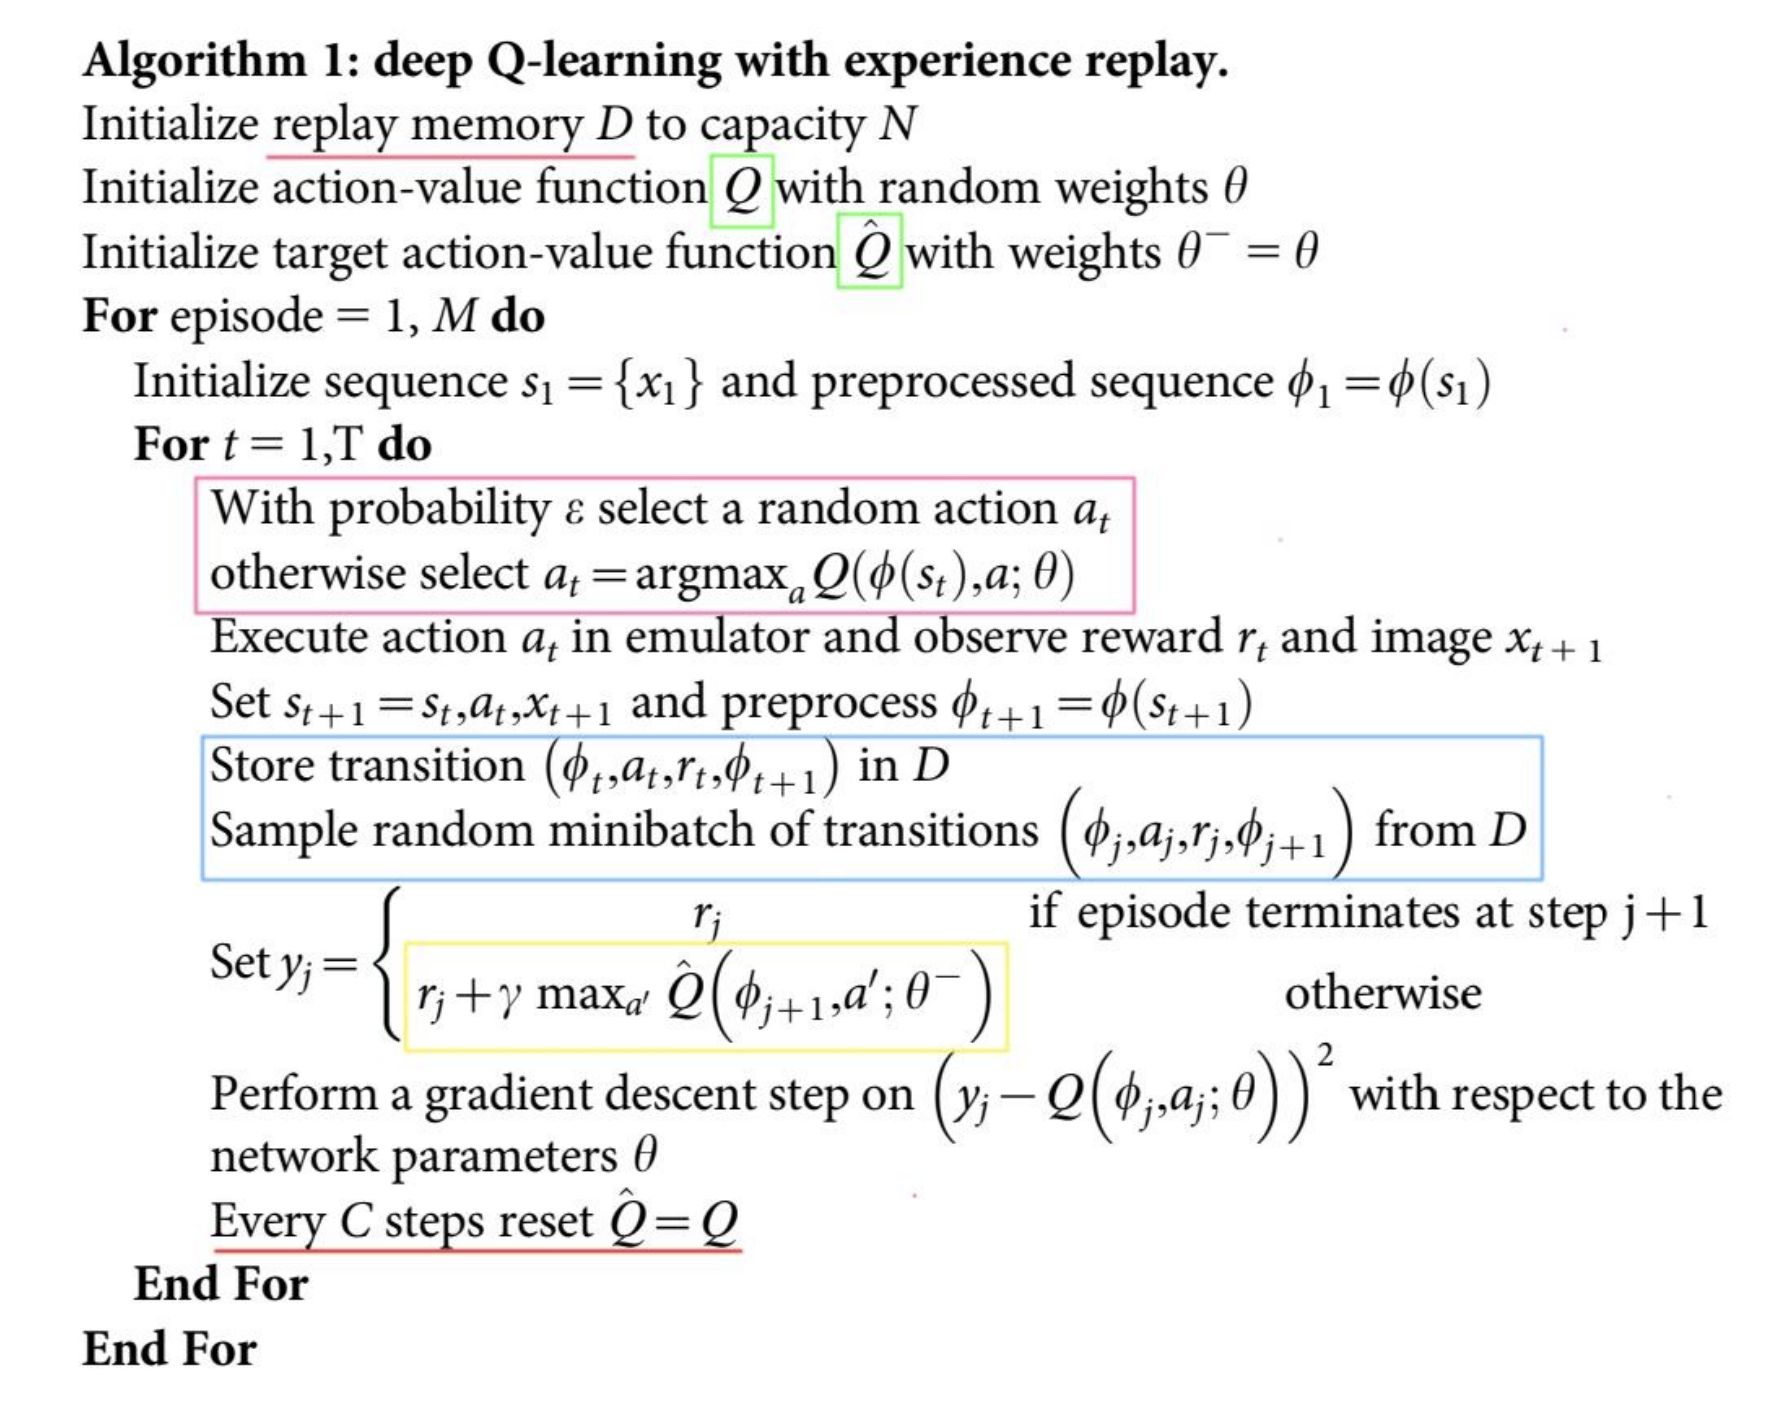

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
1/1 - 0s - loss: 0.1936 - 5ms/epoch - 5ms/step
1/1 [==============================] - 0s 26ms/step
1/1 - 0s - loss: 0.0192 - 5ms/epoch - 5ms/step
1/1 [==============================] - 0s 25ms/step
1/1 - 0s - loss: 0.2737 - 6ms/epoch - 6ms/step
1/1 [==============================] - 0s 27ms/step
1/1 - 0s - loss: 0.0041 - 5ms/epoch - 5ms/step
1/1 [==============================] - 0s 32ms/step
1/1 - 0s - loss: 0.0162 - 5ms/epoch - 5ms/step
1/1 [==============================] - 0s 28ms/step
1/1 - 0s - loss: 0.0044 - 5ms/epoch - 5ms/step
1/1 [==============================] - 0s 29ms/step
1/1 - 0s - loss: 0.0034 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 25ms/step
1/1 - 0s - loss: 5.0784e-04 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 34ms/step
1/1 - 0s - loss: 0.0039 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 33ms/step
1/1 - 0s - loss: 0.1186 - 5ms/epoch - 5ms/step
1/1 [==

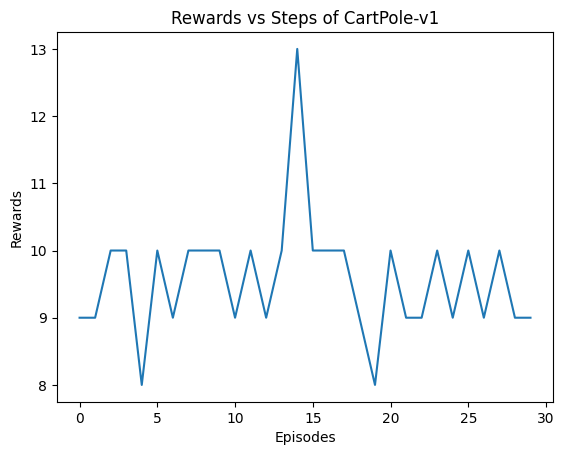

In [8]:
# @title Revised DQN Implementation
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

from collections import deque,namedtuple

Hyperparameters = namedtuple('Hyperparameters',[
    'memory_size'    ,
    'epsilon'        ,
    'epsilon_min'    ,
    'epsilon_decay'  ,
    'learning_rate'  ,
    'discount_factor',
    'batch_size'     ,
    'noOfEpisodes'   ,
    'stepsPerEpisode',
    'updateInterval' ,
    'rewardThreshold'
])

class DeepQNetwork:
    def __init__(self, env, hyperparams):
        self.env = env
        self.replayMemory = deque(maxlen=hyperparams.memory_size)
        self.epsilon = hyperparams.epsilon
        self.epsilon_min = hyperparams.epsilon_min
        self.noOfEpisodes = hyperparams.noOfEpisodes
        self.stepsPerEpisode = hyperparams.stepsPerEpisode
        self.updateInterval = hyperparams.updateInterval
        self.rewardThreshold = hyperparams.rewardThreshold
        self.epsilon_decay = (self.epsilon_min / self.epsilon) ** (1 / self.noOfEpisodes)
        self.learning_rate = hyperparams.learning_rate
        self.discount_factor = hyperparams.discount_factor
        self.batch_size = hyperparams.batch_size
        self.qNetwork = self.create_model()
        self.targetNetwork = self.create_model()
        self.syncWeights()

    def create_model(self):
        state_shape = self.env.observation_space.shape
        actions = self.env.action_space.n
        model = Sequential([
            Dense(24, input_dim=state_shape[0], activation="relu"),
            Dense(48, activation="relu"),
            Dense(24, activation="relu"),
            Dense(actions, activation="linear")
        ])
        model.compile(
            loss="mean_squared_error",
            optimizer=SGD(lr=self.learning_rate)
        )
        return model

    def syncWeights(self):
        weights = self.qNetwork.get_weights()
        self.targetNetwork.set_weights(weights)

    def getNextAction(self, state):
        epsilon = self.epsilon
        nextAction = None
        if np.random.random() < epsilon:
            nextAction = self.env.action_space.sample()
        nextAction = np.argmax(self.qNetwork.predict(state)[0])
        return nextAction

    def addToMemory(self, state, action, reward, nextState, done):
        self.replayMemory.append([state, action, reward, nextState, done])

    def predictValue(self):

        if len(self.replayMemory) < self.batch_size:
            return

        samples = random.sample(self.replayMemory, self.batch_size)
        for sample in samples:
            state, action, reward, nextState, done = sample
            target = self.targetNetwork.predict(state)
            if done:
                target[0][action] = reward
            else:
                nextQValue = max(self.targetNetwork.predict(nextState)[0])
                target[0][action] = reward + nextQValue * self.discount_factor
            self.qNetwork.fit(state, target, epochs=1, verbose=2)
    
    def train(self):
      env = self.env
      rewards = []
      noOfStates = env.observation_space.shape[0]
      print("-"*80)
      for episode in range(self.noOfEpisodes):
        epsilon = self.epsilon
        print("Training Episode : ",episode)
        print("-"*80)
        state = env.reset()
        print(len(state))
        state = np.array(state)
        state = state.reshape(1,noOfStates)

        totalReward = 0
        for timestep in range(self.stepsPerEpisode):
          action = self.getNextAction(state)
          nextState, reward, done, info = env.step(action)
          nextState = nextState.reshape(1, noOfStates)
          self.addToMemory(state, action, reward, nextState,done)
          self.predictValue()
          totalReward += reward
          if timestep % self.updateInterval == 0:
            self.syncWeights()
          
          if done or totalReward > self.rewardThreshold:
            break
        epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, epsilon)
        print("-"*80)
        print(f'{episode=},{totalReward=}')
        print("-"*80)
        rewards.append(totalReward)
      env.close()
      # Plot 1 : Episode vs Rewards
      plt.title(f'Rewards vs Steps of {env.spec.id}')
      plt.plot(list(range(self.noOfEpisodes)),rewards)
      plt.xlabel("Episodes")
      plt.ylabel("Rewards")
      plt.savefig(f'./RewardsVsEpisodes_{env.spec.id}.png')
      plt.show()

env = gym.make("CartPole-v1")

hyperparams = Hyperparameters(
    memory_size       = 200,
    epsilon           = 1,
    epsilon_min       = 0.01,
    epsilon_decay     = 0.999,
    learning_rate     = 0.01,
    discount_factor   = 0.9,
    batch_size        = 64,
    noOfEpisodes      = 30,
    stepsPerEpisode   = 100,
    updateInterval    = 5,
    rewardThreshold   = 500
)

dqn = DeepQNetwork(env, hyperparams)

dqn.train()

